In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# Step 1: Restart the Kaggle kernel first
# Click "Restart Kernel" or run this cell, then restart manually

# Step 2: After restart, run this in a NEW cell:
!pip uninstall -y torch torchvision torchaudio facenet-pytorch -q
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 -q
!pip install facenet-pytorch==2.5.3 -q

print("Installation complete. Please restart kernel again before importing.")

Installation complete. Please restart kernel again before importing.


In [4]:
!pip install --upgrade protobuf==3.20.3
!pip install tensorflow==2.14.0

In [ ]:
import os
os.kill(os.getpid(), 9)

In [5]:
# Run this in a fresh cell after restarting
from facenet_pytorch import MTCNN
print("Success , MTCNN imported correctly")

Success , MTCNN imported correctly


In [7]:
import warnings
warnings.filterwarnings("ignore")


In [8]:
import os
import cv2
import shutil
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from facenet_pytorch import MTCNN
import seaborn as sns
import json
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import glob
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, roc_curve, auc
import time
from datetime import datetime

2025-12-04 01:50:50.315692: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-04 01:50:50.316751: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-04 01:50:50.316814: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
# =============================================================================
# SECTION 1: DATASET PATHS
# =============================================================================

print("="*60)
print("MTCNN PREPROCESSING + ACCURACY")
print("="*60)

# Base path 
base_path = r'/kaggle/input/140k-real-and-fake-faces/real_vs_fake'

train_real = os.path.join('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/real')
train_fake = os.path.join('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/fake')
valid_real = os.path.join('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/real')
valid_fake = os.path.join('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/fake')
test_real = os.path.join('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real')
test_fake = os.path.join('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake')

for path in [train_real, train_fake, valid_real, valid_fake, test_real, test_fake]:
    if not os.path.exists(path):
        print(f"Path does not exist: {path}")

print(f"\nDataset Path: {base_path}")



MTCNN PREPROCESSING + ACCURACY

Dataset Path: /kaggle/input/140k-real-and-fake-faces/real_vs_fake


In [10]:
# =============================================================================
# SECTION 2: DATASET QUALITY CHECK
# =============================================================================

print("\n" + "="*60)
print("ORIGINAL DATASET STATISTICS")
print("="*60)

def count_images(path):
    if os.path.exists(path):
        return len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
    return 0
# Count original images
original_stats = {
    'train_real': count_images(train_real),
    'train_fake': count_images(train_fake),
    'valid_real': count_images(valid_real),
    'valid_fake': count_images(valid_fake),
    'test_real': count_images(test_real),
    'test_fake': count_images(test_fake)
}

print(f"\nTRAIN:")
print(f"Real: {original_stats['train_real']:,} images")
print(f"Fake: {original_stats['train_fake']:,} images")
print(f"Total: {original_stats['train_real'] + original_stats['train_fake']:,}")

print(f"\nVALIDATION:")
print(f"Real: {original_stats['valid_real']:,} images")
print(f"Fake: {original_stats['valid_fake']:,} images")
print(f"Total: {original_stats['valid_real'] + original_stats['valid_fake']:,}")

print(f"\nTEST:")
print(f"Real: {original_stats['test_real']:,} images")
print(f"Fake: {original_stats['test_fake']:,} images")
print(f"Total: {original_stats['test_real'] + original_stats['test_fake']:,}")

original_total = sum(original_stats.values())
print(f"\nGRAND TOTAL: {original_total:,} images")



ORIGINAL DATASET STATISTICS

TRAIN:
Real: 50,000 images
Fake: 50,000 images
Total: 100,000

VALIDATION:
Real: 10,000 images
Fake: 10,000 images
Total: 20,000

TEST:
Real: 10,000 images
Fake: 10,000 images
Total: 20,000

GRAND TOTAL: 140,000 images


In [11]:
# =============================================================================
# SECTION 3: QUALITY CHECKS
# =============================================================================

print("\n" + "="*60)
print("IMAGE QUALITY CHECKS")
print("="*60)

# Check sample images
print("\nChecking sample images")
sample_files = [f for f in os.listdir(train_real) if f.lower().endswith(('.jpg', '.png', '.jpeg'))][:3]
for fname in sample_files:
    img_path = os.path.join(train_real, fname)
    try:
        with Image.open(img_path) as img:
            print(f" {fname}: {img.size} | {img.mode}")
    except Exception as e:
        print(f"     {fname}: Error - {e}")

# Resolution check
def get_image_resolutions(path, limit=500):
    resolutions = []
    files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))][:limit]
    for fname in files:
        img_path = os.path.join(path, fname)
        try:
            img = cv2.imread(img_path)
            if img is not None:
                h, w = img.shape[:2]
                resolutions.append((w, h))
        except:
            continue
    return resolutions

real_res = get_image_resolutions(train_real)
fake_res = get_image_resolutions(train_fake)

print(f"\nMost common resolutions:")
print(f" Real: {Counter(real_res).most_common(3)}")
print(f" Fake: {Counter(fake_res).most_common(3)}")

# Blurriness check
def detect_blurriness(path, limit=300):
    blur_scores = []
    files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))][:limit]
    for fname in files:
        img_path = os.path.join(path, fname)
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                score = cv2.Laplacian(img, cv2.CV_64F).var()
                blur_scores.append(score)
        except:
            continue
    return blur_scores

real_blur = detect_blurriness(train_real)
fake_blur = detect_blurriness(train_fake)

print(f"\nBlur Scores (higher = sharper):")
print(f" Real Mean: {np.mean(real_blur):.2f}")
print(f" Fake Mean: {np.mean(fake_blur):.2f}")


IMAGE QUALITY CHECKS

Checking sample images
 64601.jpg: (256, 256) | RGB
 31973.jpg: (256, 256) | RGB
 30778.jpg: (256, 256) | RGB

Most common resolutions:
 Real: [((256, 256), 500)]
 Fake: [((256, 256), 500)]

Blur Scores (higher = sharper):
 Real Mean: 1215.64
 Fake Mean: 1129.78



Showing sample images:


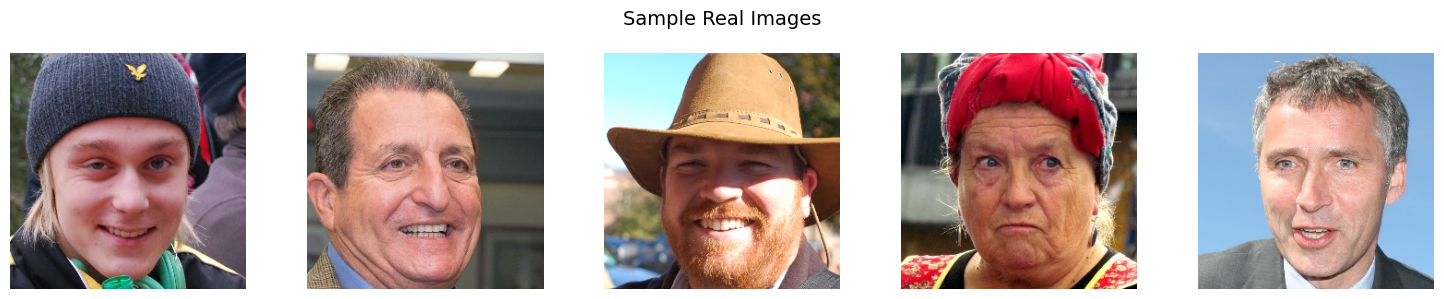

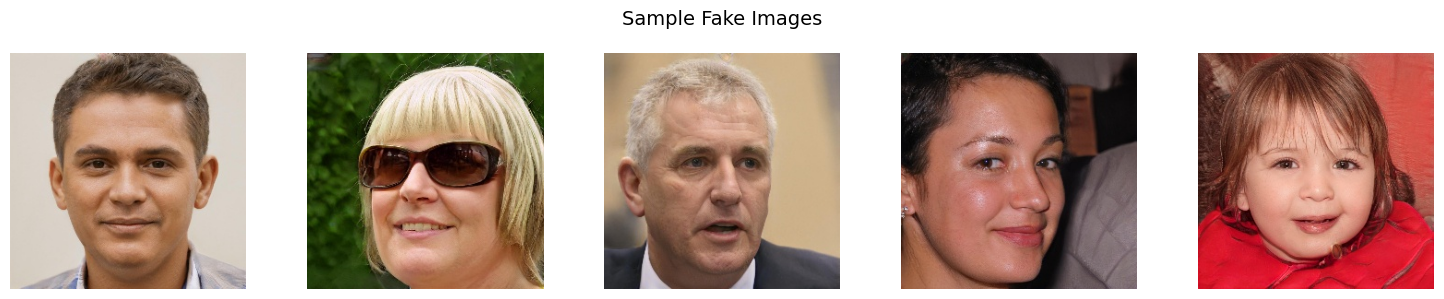

In [12]:
# =============================================================================
# SECTION 4: PREVIEW SAMPLE IMAGES
# =============================================================================

def show_samples(path, title, n=5):
    files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))][:n]
    if len(files) == 0:
        return
    
    plt.figure(figsize=(15, 3))
    for i, fname in enumerate(files):
        img = cv2.imread(os.path.join(path, fname))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

print("\nShowing sample images:")
show_samples(train_real, 'Sample Real Images')
show_samples(train_fake, 'Sample Fake Images')


In [13]:
# =============================================================================
# SECTION 5: MTCNN PREPROCESSING WITH LANDMARKS
# =============================================================================
print("\n" + "="*60)
print(" MTCNN PREPROCESSING WITH LANDMARKS")
print("="*60)


import os

# Output paths (Kaggle-compatible)
preprocessed_base = '/kaggle/working/data/preprocessed'
landmarks_base = '/kaggle/working/data/landmarks'

preprocessed_paths = {
    'train_real': os.path.join(preprocessed_base, 'train', 'real'),
    'train_fake': os.path.join(preprocessed_base, 'train', 'fake'),
    'val_real': os.path.join(preprocessed_base, 'val', 'real'),
    'val_fake': os.path.join(preprocessed_base, 'val', 'fake'),
    'test_real': os.path.join(preprocessed_base, 'test', 'real'),
    'test_fake': os.path.join(preprocessed_base, 'test', 'fake')
}

landmarks_paths = {
    'train_real': os.path.join(landmarks_base, 'train', 'real'),
    'train_fake': os.path.join(landmarks_base, 'train', 'fake'),
    'val_real': os.path.join(landmarks_base, 'val', 'real'),
    'val_fake': os.path.join(landmarks_base, 'val', 'fake'),
    'test_real': os.path.join(landmarks_base, 'test', 'real'),
    'test_fake': os.path.join(landmarks_base, 'test', 'fake')
}

# Create all directories
for path in list(preprocessed_paths.values()) + list(landmarks_paths.values()):
    os.makedirs(path, exist_ok=True)

print("Directories created successfully!")

# Check if already preprocessed
already_done = all(len(os.listdir(path)) > 0 for path in preprocessed_paths.values())

if already_done:
    print("\n Preprocessed data already exists!")
    for name, path in preprocessed_paths.items():
        count = len(os.listdir(path))
        print(f"   {name}: {count:,} images")
    print("\n Skipping preprocessing")
    
else:
    print("\n Starting MTCNN preprocessing with landmarks")
    
    # Initialize MTCNN
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f" Device: {device}")
    
    mtcnn = MTCNN(
        image_size=224,
        margin=20,
        keep_all=False,
        device=device,
        post_process=False
    )
    
    print(" MTCNN initialized")
    print(" Face Landmarks detection enabled")
    
    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1
    )
    
    print(" Augmentation configured")
    
    def preprocess_and_augment(input_dir, output_dir, prefix):
        counter = 0
        skipped = 0
        landmarks_data = []
        
        files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        for file in tqdm(files, desc=f'   {prefix}'):
            try:
                img_path = os.path.join(input_dir, file)
                
                # Check file exists
                if not os.path.isfile(img_path):
                    continue
                
                # Load image
                img_pil = Image.open(img_path).convert('RGB')
                
                # Face Detection + Landmarks Extraction
                boxes, probs, landmarks = mtcnn.detect(img_pil, landmarks=True)
                
                if boxes is None or len(boxes) == 0:
                    skipped += 1
                    continue
                
                # Get first (best) face
                box = boxes[0]
                prob = probs[0] if probs is not None else 0
                landmark = landmarks[0] if landmarks is not None else None
                
                # Save Landmarks Information
                if landmark is not None:
                    landmarks_data.append({
                        'file': f'{prefix}_{counter}.jpg',
                        'confidence': float(prob),
                        'landmarks': landmark.tolist(),
                        'points': {
                            'left_eye': landmark[0].tolist(),
                            'right_eye': landmark[1].tolist(),
                            'nose': landmark[2].tolist(),
                            'left_mouth': landmark[3].tolist(),
                            'right_mouth': landmark[4].tolist()
                        }
                    })
                
                # Crop Face
                x1, y1, x2, y2 = [int(b) for b in box]
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(img_pil.width, x2), min(img_pil.height, y2)
                
                face_img_pil = img_pil.crop((x1, y1, x2, y2))
                
                # Resize to 224x224
                face_img_pil = face_img_pil.resize((224, 224), Image.BILINEAR)
                face_img = np.array(face_img_pil) / 255.0
                
                # Save Original Preprocessed Image
                save_path = os.path.join(output_dir, f'{prefix}_{counter}.jpg')
                Image.fromarray((face_img * 255).astype(np.uint8)).save(save_path, quality=95)
                
                # Data Augmentation (2 variants)
                img_exp = np.expand_dims(face_img, 0)
                aug_iter = datagen.flow(img_exp, batch_size=1)
                for i in range(2):
                    aug_img = next(aug_iter)[0]
                    aug_path = os.path.join(output_dir, f'{prefix}_{counter}_aug{i}.jpg')
                    Image.fromarray((aug_img * 255).astype(np.uint8)).save(aug_path, quality=95)
                counter += 1
            except Exception:
                skipped += 1
                continue
        
        # Save Landmarks to JSON File
        if landmarks_data:
            landmarks_file = os.path.join(landmarks_base, f'{prefix}_landmarks.json')
            with open(landmarks_file, 'w') as f:
                json.dump(landmarks_data, f, indent=2)
            print(f"\n Landmarks saved: {os.path.basename(landmarks_file)}")
        print(f"\n {prefix}:")
        print(f"Processed: {counter:,}")
        print(f"Skipped: {skipped:,}")
        print(f"Landmarks detected: {len(landmarks_data):,}")
        print(f"Total output: {counter*3:,} (with augmentation)")
        
        return counter, skipped
    
    # Process all datasets
    print("\n Processing datasets")
    stats = {}
    print("\n TRAIN SET:")
    p, s = preprocess_and_augment(train_real, preprocessed_paths['train_real'], 'train_real')
    stats['train_real'] = {'processed': p, 'skipped': s}
    p, s = preprocess_and_augment(train_fake, preprocessed_paths['train_fake'], 'train_fake')
    stats['train_fake'] = {'processed': p, 'skipped': s}
    print("\n VALIDATION SET:")
    p, s = preprocess_and_augment(valid_real, preprocessed_paths['val_real'], 'val_real')
    stats['val_real'] = {'processed': p, 'skipped': s}
    p, s = preprocess_and_augment(valid_fake, preprocessed_paths['val_fake'], 'val_fake')
    stats['val_fake'] = {'processed': p, 'skipped': s}
    print("\n TEST SET:")
    p, s = preprocess_and_augment(test_real, preprocessed_paths['test_real'], 'test_real')
    stats['test_real'] = {'processed': p, 'skipped': s}
    p, s = preprocess_and_augment(test_fake, preprocessed_paths['test_fake'], 'test_fake')
    stats['test_fake'] = {'processed': p, 'skipped': s}
    print("\n" + "="*60)
    print(" PREPROCESSING WITH LANDMARKS COMPLETE")
    print("="*60)



 MTCNN PREPROCESSING WITH LANDMARKS
Directories created successfully!

 Starting MTCNN preprocessing with landmarks
 Device: cuda
 MTCNN initialized
 Face Landmarks detection enabled
 Augmentation configured

 Processing datasets

 TRAIN SET:


   train_real: 100%|██████████| 50000/50000 [50:10<00:00, 16.61it/s] 



 Landmarks saved: train_real_landmarks.json

 train_real:
Processed: 49,991
Skipped: 9
Landmarks detected: 49,991
Total output: 149,973 (with augmentation)


   train_fake: 100%|██████████| 50000/50000 [53:39<00:00, 15.53it/s]  



 Landmarks saved: train_fake_landmarks.json

 train_fake:
Processed: 49,998
Skipped: 2
Landmarks detected: 49,998
Total output: 149,994 (with augmentation)

 VALIDATION SET:


   val_real: 100%|██████████| 10000/10000 [10:32<00:00, 15.81it/s]



 Landmarks saved: val_real_landmarks.json

 val_real:
Processed: 9,998
Skipped: 2
Landmarks detected: 9,998
Total output: 29,994 (with augmentation)


   val_fake: 100%|██████████| 10000/10000 [10:01<00:00, 16.63it/s]



 Landmarks saved: val_fake_landmarks.json

 val_fake:
Processed: 10,000
Skipped: 0
Landmarks detected: 10,000
Total output: 30,000 (with augmentation)

 TEST SET:


   test_real: 100%|██████████| 10000/10000 [09:45<00:00, 17.07it/s]



 Landmarks saved: test_real_landmarks.json

 test_real:
Processed: 9,998
Skipped: 2
Landmarks detected: 9,998
Total output: 29,994 (with augmentation)


   test_fake: 100%|██████████| 10000/10000 [09:54<00:00, 16.83it/s]



 Landmarks saved: test_fake_landmarks.json

 test_fake:
Processed: 9,999
Skipped: 1
Landmarks detected: 9,999
Total output: 29,997 (with augmentation)

 PREPROCESSING WITH LANDMARKS COMPLETE


In [14]:
# =============================================================================
# ORIGINAL DATASET STATISTICS
# =============================================================================

print("\n" + "="*60)
print(" ORIGINAL DATASET STATISTICS")
print("="*60)

original_paths = {
    'train_real': train_real,
    'train_fake': train_fake,
    'val_real': valid_real,
    'val_fake': valid_fake,
    'test_real': test_real,
    'test_fake': test_fake
}

original_stats = {}

for name, path in original_paths.items():
    if os.path.exists(path):
        count = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        original_stats[name] = count
        print(f"   {name}: {count:,} images")
    else:
        original_stats[name] = 0
        print(f"   {name}: folder not found")

print("\n Original dataset statistics collected successfully.")



 ORIGINAL DATASET STATISTICS
   train_real: 50,000 images
   train_fake: 50,000 images
   val_real: 10,000 images
   val_fake: 10,000 images
   test_real: 10,000 images
   test_fake: 10,000 images

 Original dataset statistics collected successfully.



 Previewing preprocessed images: 


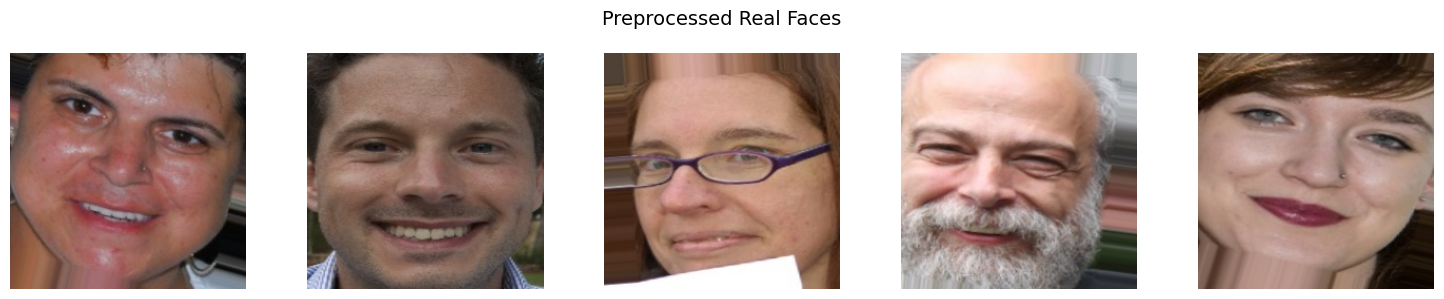

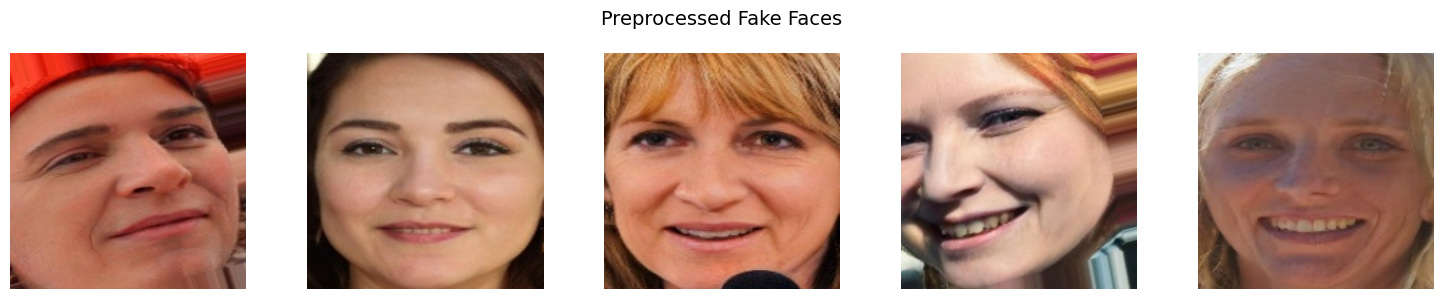

In [15]:
# =============================================================================
# SECTION 6: PREVIEW PREPROCESSED IMAGES
# =============================================================================

print("\n Previewing preprocessed images: ")
show_samples(preprocessed_paths['train_real'], 'Preprocessed Real Faces')
show_samples(preprocessed_paths['train_fake'], 'Preprocessed Fake Faces')


In [16]:
# =============================================================================
# SECTION 7: ACCURACY & STATISTICS
# =============================================================================

print("\n" + "="*60)
print(" PREPROCESSING ACCURACY & STATISTICS")
print("="*60)

# Count preprocessed (divide by 3 for actual count without augmentation)
preprocessed_stats = {}
for name, path in preprocessed_paths.items():
    total = len(os.listdir(path))
    actual = total // 3
    preprocessed_stats[name] = {'total': total, 'actual': actual}

print(f"\n MTCNN Face Detection Success Rate:")

for key in ['train_real', 'train_fake', 'val_real', 'val_fake', 'test_real', 'test_fake']:
    original = original_stats.get(key, 0)
    processed = preprocessed_stats[key]['actual']
    success_rate = (processed / original * 100) if original > 0 else 0
    print(f"   {key}: {success_rate:.2f}% ({processed:,}/{original:,})")

# Overall stats
train_total = preprocessed_stats['train_real']['total'] + preprocessed_stats['train_fake']['total']
val_total = preprocessed_stats['val_real']['total'] + preprocessed_stats['val_fake']['total']
test_total = preprocessed_stats['test_real']['total'] + preprocessed_stats['test_fake']['total']

print(f"\n Preprocessed Dataset (with augmentation):")
print(f"TRAIN: {train_total:,} images")
print(f"VAL:   {val_total:,} images")
print(f"TEST:  {test_total:,} images")
print(f"TOTAL: {train_total + val_total + test_total:,} images")

# Landmarks statistics
print(f"\n Face Landmarks Statistics:")
if os.path.exists(landmarks_base):
    landmarks_files = [f for f in os.listdir(landmarks_base) if f.endswith('.json')]
    total_landmarks = 0
    
    for lm_file in sorted(landmarks_files):
        lm_path = os.path.join(landmarks_base, lm_file)
        try:
            with open(lm_path, 'r') as f:
                data = json.load(f)
                total_landmarks += len(data)
                print(f"   {lm_file}: {len(data):,} faces with landmarks")
        except:
            continue
    
    print(f"Total landmarks extracted: {total_landmarks:,}")
else:
    print("No landmarks data found")

# Data balance
train_real_count = preprocessed_stats['train_real']['total']
train_fake_count = preprocessed_stats['train_fake']['total']
train_balance = (train_real_count / (train_real_count + train_fake_count) * 100) if (train_real_count + train_fake_count) > 0 else 0

val_real_count = preprocessed_stats['val_real']['total']
val_fake_count = preprocessed_stats['val_fake']['total']
val_balance = (val_real_count / (val_real_count + val_fake_count) * 100) if (val_real_count + val_fake_count) > 0 else 0

test_real_count = preprocessed_stats['test_real']['total']
test_fake_count = preprocessed_stats['test_fake']['total']
test_balance = (test_real_count / (test_real_count + test_fake_count) * 100) if (test_real_count + test_fake_count) > 0 else 0

print(f"\n Data Balance:")
print(f"Train: {train_balance:.1f}% Real / {100-train_balance:.1f}% Fake")
print(f"Val:   {val_balance:.1f}% Real / {100-val_balance:.1f}% Fake")
print(f"Test:  {test_balance:.1f}% Real / {100-test_balance:.1f}% Fake")

if 45 <= train_balance <= 55:
    print("\n Dataset is well-balanced")
else:
    print("\n Dataset may be imbalanced")

# =============================================================================
# MTCNN ACCURACY CALCULATION
# =============================================================================

print(f"\nMTCNN MODEL ACCURACY:")

# Calculate overall detection accuracy
total_original = sum(original_stats.values())
total_detected = sum(preprocessed_stats[key]['actual'] for key in preprocessed_stats.keys())
total_skipped = total_original - total_detected

overall_accuracy = (total_detected / total_original * 100) if total_original > 0 else 0

print(f"\n Overall Detection Accuracy: {overall_accuracy:.2f}%")
print(f"\n Output Directories:")
print(f"   Preprocessed images: {preprocessed_base}")
print(f"   Face landmarks JSON: {landmarks_base}")



 PREPROCESSING ACCURACY & STATISTICS

 MTCNN Face Detection Success Rate:
   train_real: 99.98% (49,991/50,000)
   train_fake: 100.00% (49,998/50,000)
   val_real: 99.98% (9,998/10,000)
   val_fake: 100.00% (10,000/10,000)
   test_real: 99.98% (9,998/10,000)
   test_fake: 99.99% (9,999/10,000)

 Preprocessed Dataset (with augmentation):
TRAIN: 299,967 images
VAL:   59,994 images
TEST:  59,991 images
TOTAL: 419,952 images

 Face Landmarks Statistics:
   test_fake_landmarks.json: 9,999 faces with landmarks
   test_real_landmarks.json: 9,998 faces with landmarks
   train_fake_landmarks.json: 49,998 faces with landmarks
   train_real_landmarks.json: 49,991 faces with landmarks
   val_fake_landmarks.json: 10,000 faces with landmarks
   val_real_landmarks.json: 9,998 faces with landmarks
Total landmarks extracted: 139,984

 Data Balance:
Train: 50.0% Real / 50.0% Fake
Val:   50.0% Real / 50.0% Fake
Test:  50.0% Real / 50.0% Fake

 Dataset is well-balanced

MTCNN MODEL ACCURACY:

 Overall De

In [ ]:
# ============================================================================
# COMPLETE ANTI-SPOOFING PIPELINE - EfficientNet-B1 (GPU-Optimized)
# ============================================================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras import regularizers, mixed_precision

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from datetime import datetime
import json
import os
from tqdm import tqdm

# ============================================================================
# STEP 1: GPU DETECTION & OPTIMIZATION
# ============================================================================
print("="*80)
print(" GPU CONFIGURATION & OPTIMIZATION")
print("="*80)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # تقليل الرسائل المزعجة

# عشان اتاكد ال gpu شغال ولا لا
gpus = tf.config.list_physical_devices('GPU')
print(f"\nTensorFlow version: {tf.__version__}")
print(f"Number of GPUs Available: {len(gpus)}")

if gpus:
    for gpu in gpus:
        print(f"  - {gpu}")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(f"error {e}")
    
    # عشان اتاكد من انو ال gpu مستخدم
    print(f"TensorFlow built with CUDA: {tf.test.is_built_with_cuda()}")
else:
    print("\nWARNING: No GPU detected!")
    print("Please enable GPU: Runtime → Change runtime type → T4 GPU")

try:
    tf.config.optimizer.set_jit(True)
    print("XLA optimization enabled")
except:
    print("XLA not available")

USE_MIXED_PRECISION = True
if USE_MIXED_PRECISION:
    try:
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print(f"Mixed precision enabled: {policy.name}")
    except:
        print("Mixed precision not supported, using float32")
        USE_MIXED_PRECISION = False

print("="*80)

# ============================================================================
# STEP 2: CONFIGURATION
# ============================================================================
class Config:
    PREPROCESSED_BASE = Path(r'/kaggle/working/data/preprocessed')
    OUTPUT_BASE = Path(r'/kaggle/working/antispoofing_output')

    # Model parameters
    IMG_SIZE = 224
    BATCH_SIZE = 64
    EPOCHS = 30
    LEARNING_RATE = 1e-4
    FINE_TUNE_EPOCHS = 15
    FINE_TUNE_LR = 1e-5

    DEVICE = 'GPU' if gpus else 'CPU'

# Create output directories
Config.OUTPUT_BASE.mkdir(parents=True, exist_ok=True)
(Config.OUTPUT_BASE / 'checkpoints').mkdir(exist_ok=True)
(Config.OUTPUT_BASE / 'plots').mkdir(exist_ok=True)

print(f"\n{'='*80}")
print(" CONFIGURATION")
print("="*80)
print(f"\nPaths:")
print(f"Preprocessed Data: {Config.PREPROCESSED_BASE}")
print(f"Output: {Config.OUTPUT_BASE}")
print(f"\nModel Settings:")
print(f"Device: {Config.DEVICE}")
print(f"Image Size: {Config.IMG_SIZE}x{Config.IMG_SIZE}")
print(f"Batch Size: {Config.BATCH_SIZE}")
print(f"Phase 1 Epochs: {Config.EPOCHS}")
print(f"Phase 2 Epochs: {Config.FINE_TUNE_EPOCHS}")
print(f"Learning Rate: {Config.LEARNING_RATE}")
print(f"Fine-tune LR: {Config.FINE_TUNE_LR}")

# ============================================================================
# STEP 3: VERIFY DATA STRUCTURE
# ============================================================================
print(f"\n{'='*80}")
print(" DATA VERIFICATION")
print("="*80)

def verify_or_create_path(path):
    if not path.exists():
        print(f"Path not found. Creating: {path}")
        path.mkdir(parents=True, exist_ok=True)
    else:
        print(f"Path exists: {path}")

# Define dataset splits
splits = ['train', 'val', 'test']
classes = ['real', 'fake']

print("\nVerifying directory structure:")
for split in splits:
    for cls in classes:
        split_path = Config.PREPROCESSED_BASE / split / cls
        verify_or_create_path(split_path)

# Verify data statistics
def verify_data_structure():
    stats = {}
    missing_data = False
    total_images = 0
    
    for split in splits:
        real_path = Config.PREPROCESSED_BASE / split / 'real'
        fake_path = Config.PREPROCESSED_BASE / split / 'fake'
        
        real_count = len(list(real_path.glob('*.jpg'))) + len(list(real_path.glob('*.png')))
        fake_count = len(list(fake_path.glob('*.jpg'))) + len(list(fake_path.glob('*.png')))
        
        total_count = real_count + fake_count
        total_images += total_count
        
        stats[split] = {
            'real': real_count,
            'fake': fake_count,
            'total': total_count
        }
        
        print(f"\n{split.upper()} Set:")
        print(f"Real: {real_count:,}")
        print(f"Fake: {fake_count:,}")
        print(f"Total: {total_count:,}")
        if total_count > 0:
            print(f"Balance: {real_count/total_count*100:.1f}% Real / {fake_count/total_count*100:.1f}% Fake")
        else:
            print("WARNING: No images found in this split!")
            missing_data = True
    
    if missing_data:
        print("\nWARNING: Some splits have no images. Please run MTCNN preprocessing first.")
    
    return stats, total_images

data_stats, total_images = verify_data_structure()
print(f"\n{'='*60}")
print(f"Total preprocessed images: {total_images:,}")
print("="*60)

if total_images == 0:
    print("\nERROR: No images found! Please run preprocessing first.")
    print("Exiting")
    exit()

# ============================================================================
# STEP 4: DATA GENERATORS
# ============================================================================
print(f"\n{'='*80}")
print(" SETTING UP DATA GENERATORS")
print("="*80)

# EfficientNet expects [0, 255] values
train_datagen = ImageDataGenerator() 
val_test_datagen = ImageDataGenerator() 

# Load data with optimized settings
AUTOTUNE = tf.data.AUTOTUNE

train_generator = train_datagen.flow_from_directory(
    Config.PREPROCESSED_BASE / 'train',
    target_size=(Config.IMG_SIZE, Config.IMG_SIZE),
    batch_size=Config.BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    Config.PREPROCESSED_BASE / 'val',
    target_size=(Config.IMG_SIZE, Config.IMG_SIZE),
    batch_size=Config.BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    Config.PREPROCESSED_BASE / 'test',
    target_size=(Config.IMG_SIZE, Config.IMG_SIZE),
    batch_size=Config.BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(f"\nData Generators Created:")
print(f"Train: {train_generator.samples:,} samples")
print(f"Val: {val_generator.samples:,} samples")
print(f"Test: {test_generator.samples:,} samples")

# Class mapping
print(f"\nClass Mapping:")
for cls, idx in train_generator.class_indices.items():
    print(f"{cls}: {idx}")

# Calculate steps
steps_per_epoch = train_generator.samples // Config.BATCH_SIZE
validation_steps = val_generator.samples // Config.BATCH_SIZE
test_steps = test_generator.samples // Config.BATCH_SIZE

print(f"\nTraining Steps:")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Test steps: {test_steps}")

# ============================================================================
# STEP 5: BUILD MODEL
# ============================================================================
print(f"\n{'='*80}")
print(" BUILDING EFFICIENTNET-B1 ANTI-SPOOFING MODEL")
print("="*80)

tf.keras.backend.clear_session()

def build_antispoofing_model():
    inputs = layers.Input(shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3))
    
    # EfficientNet-B1 backbone
    base_model = EfficientNetB1(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        pooling=None
    )
    
    # Freeze base model initially
    base_model.trainable = False
    
    x = base_model.output
    
    # Anti-spoofing specific layers
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    
    # Dense layers with regularization
    x = layers.Dense(512, kernel_regularizer=regularizers.l2(0.01), name='dense_1')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.Activation('relu', name='relu_1')(x)
    x = layers.Dropout(0.5, name='dropout_1')(x)
    
    x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.01), name='dense_2')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.Activation('relu', name='relu_2')(x)
    x = layers.Dropout(0.4, name='dropout_2')(x)
    
    x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.01), name='dense_3')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.Activation('relu', name='relu_3')(x)
    x = layers.Dropout(0.3, name='dropout_3')(x)
    
    # Output layer
    if USE_MIXED_PRECISION:
        # For mixed precision, use float32 for final layer
        x = layers.Dense(1, activation='sigmoid', dtype='float32', name='output')(x)
    else:
        x = layers.Dense(1, activation='sigmoid', name='output')(x)
    
    outputs = x
    
    model = Model(inputs=inputs, outputs=outputs, name='EfficientNetB1_AntiSpoofing')
    
    return model, base_model

print("\nBuilding model...")
model, base_model = build_antispoofing_model()

print(f"\nModel Architecture:")
print(f"Backbone: EfficientNet-B1")
print(f"Input Shape: {Config.IMG_SIZE}x{Config.IMG_SIZE}x3")
print(f"Total Parameters: {model.count_params():,}")
print(f"Trainable Parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
print(f"Non-trainable Parameters: {sum([tf.size(w).numpy() for w in model.non_trainable_weights]):,}")

# ============================================================================
# STEP 6: CALCULATE CLASS WEIGHTS
# ============================================================================
print(f"\n{'='*80}")
print(" CALCULATING CLASS WEIGHTS")
print("="*80)

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print(f"\nClass Weights:")
for cls, weight in class_weight_dict.items():
    cls_name = 'Fake' if cls == 0 else 'Real'
    print(f"  {cls_name} (Class {cls}): {weight:.4f}")

# ============================================================================
# STEP 7: COMPILE MODEL
# ============================================================================
print(f"\n{'='*80}")
print(" COMPILING MODEL")
print("="*80)

model.compile(
    optimizer=Adam(learning_rate=Config.LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

print(f"\nModel Compiled:")
print(f"Optimizer: Adam (lr={Config.LEARNING_RATE})")
print(f"Loss: Binary Crossentropy")
print(f"Metrics: Accuracy, AUC, Precision, Recall")

# ============================================================================
# STEP 8: SETUP CALLBACKS
# ============================================================================
print(f"\n{'='*80}")
print(" SETTING UP CALLBACKS")
print("="*80)

checkpoint_dir = Config.OUTPUT_BASE / 'checkpoints'

callbacks = [
    ModelCheckpoint(
        str(checkpoint_dir / 'best_model.keras'),
        monitor='val_auc',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_auc',
        patience=7,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    CSVLogger(
        str(Config.OUTPUT_BASE / 'training_log.csv'),
        separator=',',
        append=False
    )
]

print(f"\nCallbacks configured:")
print(f"ModelCheckpoint (monitor: val_auc, mode: max)")
print(f"EarlyStopping (patience: 7, monitor: val_auc)")
print(f"ReduceLROnPlateau (factor: 0.5, patience: 3)")
print(f"CSVLogger")

# ============================================================================
# STEP 9: PHASE 1 TRAINING (FROZEN BASE) 
# ============================================================================
print(f"\n{'='*80}")
print(" PHASE 1: TRAINING WITH FROZEN BASE (GPU-OPTIMIZED)")
print("="*80)

print(f"\nTraining Configuration:")
print(f"Device: {Config.DEVICE}")
print(f"Mixed Precision: {'Enabled (float16)' if USE_MIXED_PRECISION else 'Disabled (float32)'}")
print(f"Epochs: {Config.EPOCHS}")
print(f"Batch Size: {Config.BATCH_SIZE}")
print(f"Learning Rate: {Config.LEARNING_RATE}")
print(f"Base Model: Frozen")
print(f"Steps per Epoch: {steps_per_epoch}")
print(f"Validation Steps: {validation_steps}")

print(f"\n{'='*60}")
print("Starting Phase 1 Training...")
print("="*60 + "\n")

try:
    history_phase1 = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=Config.EPOCHS,
        validation_data=val_generator,
        validation_steps=validation_steps,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    print(f"\n{'='*60}")
    print("Phase 1 Training Completed")
    print("="*60)
    
    # Save Phase 1 model
    phase1_model_path = checkpoint_dir / 'phase1_model.keras'
    model.save(str(phase1_model_path))
    print(f"Phase 1 model saved: {phase1_model_path}")
    
except Exception as e:
    print(f"\nERROR during Phase 1 training: {e}")
    raise

# ============================================================================
# STEP 10: PHASE 2 TRAINING (FINE-TUNING)
# ============================================================================
print(f"\n{'='*80}")
print(" PHASE 2: FINE-TUNING (UNFREEZING TOP LAYERS)")
print("="*80)

# Unfreeze top layers
base_model.trainable = True

# Freeze bottom layers (only train top 50 layers)
freeze_layers = len(base_model.layers) - 50
for i, layer in enumerate(base_model.layers):
    if i < freeze_layers:
        layer.trainable = False
    else:
        layer.trainable = True

trainable_layers = sum([1 for l in model.layers if l.trainable])
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])

print(f"\nModel prepared for fine-tuning:")
print(f"Total layers: {len(model.layers)}")
print(f"Trainable layers: {trainable_layers}")
print(f"Frozen layers: {len(model.layers) - trainable_layers}")
print(f"Trainable parameters: {trainable_params:,}")

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=Config.FINE_TUNE_LR),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

print(f"\nModel recompiled:")
print(f"New Learning Rate: {Config.FINE_TUNE_LR}")
print(f"Epochs: {Config.FINE_TUNE_EPOCHS}")

print(f"\n{'='*60}")
print("Starting Phase 2 Training (Fine-tuning)...")
print("="*60 + "\n")

try:
    history_phase2 = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=Config.FINE_TUNE_EPOCHS,
        validation_data=val_generator,
        validation_steps=validation_steps,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    print(f"\n{'='*60}")
    print("Phase 2 Fine-tuning Completed!")
    print("="*60)
    
except Exception as e:
    print(f"\nERROR during Phase 2 training: {e}")
    raise

# ============================================================================
# STEP 11: MODEL EVALUATION
# ============================================================================
print(f"\n{'='*80}")
print(" MODEL EVALUATION ON TEST SET")
print("="*80)

print("\nEvaluating model on test set")

test_results = model.evaluate(
    test_generator,
    steps=test_steps,
    verbose=1
)

print(f"\n{'='*60}")
print("TEST RESULTS")
print("="*60)
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]*100:.2f}%")
print(f"AUC: {test_results[2]:.4f}")
print(f"Precision: {test_results[3]*100:.2f}%")
print(f"Recall: {test_results[4]*100:.2f}%")

# ============================================================================
# STEP 12: DETAILED PREDICTIONS
# ============================================================================
print(f"\n{'='*80}")
print(" GENERATING DETAILED PREDICTIONS")
print("="*80)

y_true = []
y_pred_proba = []
y_pred = []

test_generator.reset()
print("\nPredicting on test set")

for i in tqdm(range(test_steps), desc='Predicting'):
    try:
        X_batch, y_batch = next(test_generator)
        pred_proba = model.predict(X_batch, verbose=0)
        
        y_true.extend(y_batch)
        y_pred_proba.extend(pred_proba.flatten())
        y_pred.extend((pred_proba > 0.5).astype(int).flatten())
    except StopIteration:
        break

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# Classification report
print(f"\n{'='*60}")
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=['Fake', 'Real'], digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(f"\n{'='*60}")
print("CONFUSION MATRIX")
print("="*60)
print(cm)
print("\nPredicted")
print(" Fake  Real")
print(f"Actual Fake  {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"Real  {cm[1,0]:4d}  {cm[1,1]:4d}")

# Security metrics
tn, fp, fn, tp = cm.ravel()
far = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Acceptance Rate
frr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Rejection Rate
accuracy = (tp + tn) / (tp + tn + fp + fn)

print(f"\n{'='*60}")
print("SECURITY METRICS")
print("="*60)
print(f"False Acceptance Rate (FAR): {far*100:.4f}%")
print(f"False Rejection Rate (FRR):  {frr*100:.4f}%")
print(f"Overall Accuracy: {accuracy*100:.2f}%")

# AUC-ROC
auc_score = roc_auc_score(y_true, y_pred_proba)
print(f"AUC-ROC Score: {auc_score:.4f}")

# ============================================================================
# STEP 13: SAVE RESULTS
# ============================================================================
print(f"\n{'='*80}")
print(" SAVING RESULTS")
print("="*80)

results = {
    'model': 'EfficientNet-B1',
    'device': Config.DEVICE,
    'mixed_precision': USE_MIXED_PRECISION,
    'batch_size': Config.BATCH_SIZE,
    'phase1_epochs': Config.EPOCHS,
    'phase2_epochs': Config.FINE_TUNE_EPOCHS,
    'test_loss': float(test_results[0]),
    'test_accuracy': float(test_results[1]),
    'test_auc': float(test_results[2]),
    'test_precision': float(test_results[3]),
    'test_recall': float(test_results[4]),
    'far': float(far),
    'frr': float(frr),
    'auc_roc': float(auc_score),
    'confusion_matrix': cm.tolist(),
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

results_file = Config.OUTPUT_BASE / 'evaluation_results.json'
with open(results_file, 'w') as f:
    json.dump(results, f, indent=4)

print(f"\nResults saved to: {results_file}")

# ============================================================================
# STEP 14: VISUALIZATION
# ============================================================================
print(f"\n{'='*80}")
print(" GENERATING VISUALIZATIONS")
print("="*80)

# Combine histories
history_combined = {
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss'],
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'auc': history_phase1.history['auc'] + history_phase2.history['auc'],
    'val_auc': history_phase1.history['val_auc'] + history_phase2.history['val_auc']
}

# Create comprehensive plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('EfficientNet-B1 Anti-Spoofing Training Results', fontsize=16, fontweight='bold')

# Plot 1: Loss
axes[0, 0].plot(history_combined['loss'], label='Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(history_combined['val_loss'], label='Val Loss', marker='s', linewidth=2)
axes[0, 0].axvline(x=Config.EPOCHS, color='r', linestyle='--', linewidth=2, label='Fine-tuning Start')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Accuracy
axes[0, 1].plot(history_combined['accuracy'], label='Train Acc', marker='o', linewidth=2)
axes[0, 1].plot(history_combined['val_accuracy'], label='Val Acc', marker='s', linewidth=2)
axes[0, 1].axvline(x=Config.EPOCHS, color='r', linestyle='--', linewidth=2, label='Fine-tuning Start')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: AUC
axes[1, 0].plot(history_combined['auc'], label='Train AUC', marker='o', linewidth=2)
axes[1, 0].plot(history_combined['val_auc'], label='Val AUC', marker='s', linewidth=2)
axes[1, 0].axvline(x=Config.EPOCHS, color='r', linestyle='--', linewidth=2, label='Fine-tuning Start')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('AUC', fontsize=12)
axes[1, 0].set_title('Training & Validation AUC', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'],
            cbar_kws={'label': 'Count'}, annot_kws={'size': 14, 'weight': 'bold'})
axes[1, 1].set_xlabel('Predicted', fontsize=12)
axes[1, 1].set_ylabel('True', fontsize=12)
axes[1, 1].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plot_path = Config.OUTPUT_BASE / 'plots' / 'training_evaluation.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"\nTraining plot saved: {plot_path}")
plt.show()

# ============================================================================
# STEP 15: SAVE FINAL MODEL
# ============================================================================
print(f"\n{'='*80}")
print(" SAVING FINAL MODEL")
print("="*80)

final_model_path = checkpoint_dir / 'final_model.keras'
model.save(str(final_model_path))
print(f"\nFinal model saved: {final_model_path}")

# ============================================================================
# STEP 16: FINAL SUMMARY
# ============================================================================
print(f"\n{'='*80}")
print("ANTI-SPOOFING PIPELINE COMPLETED SUCCESSFULLY")
print("="*80)

print(f"\n{'='*60}")
print("FINAL PERFORMANCE SUMMARY")
print("="*60)
print(f"Model:             EfficientNet-B1")
print(f"Device:            {Config.DEVICE}")
print(f"Mixed Precision:   {'Enabled' if USE_MIXED_PRECISION else 'Disabled'}")
print(f"Total Training:    {Config.EPOCHS + Config.FINE_TUNE_EPOCHS} epochs")
print(f"\nTest Metrics:")
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]*100:.2f}%")
print(f"AUC: {test_results[2]:.4f}")
print(f"Precision: {test_results[3]*100:.2f}%")
print(f"Recall: {test_results[4]*100:.2f}%")
print(f"FAR: {far*100:.4f}%")
print(f"FRR: {frr*100:.4f}%")
print(f"AUC-ROC: {auc_score:.4f}")

print(f"\nModel & Results saved at:")
print(f"Final Model: {final_model_path}")
print(f"Evaluation JSON: {results_file}")
print(f"Training Plot: {plot_path}")

print(f"\n{'='*60}")
print("PIPELINE COMPLETED SUCCESSFULLY!")
print(f"{'='*60}\n")


Using device: cuda

Training ArcFace Model
Dataset ready: 9164 images, 5749 identities

Training ARCFACE Model


Epoch 1/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.71it/s, acc=4.57%]


Epoch 1: Train=4.57% | Val=8.41% | Best=0.00%


Epoch 2/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.88it/s, acc=12.41%]


Epoch 2: Train=12.41% | Val=10.92% | Best=8.41%


Epoch 3/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.94it/s, acc=19.93%]


Epoch 3: Train=19.93% | Val=13.65% | Best=10.92%


Epoch 4/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.71it/s, acc=28.11%]


Epoch 4: Train=28.11% | Val=12.23% | Best=13.65%


Epoch 5/30 [Train]: 100%|██████████| 128/128 [00:11<00:00, 11.62it/s, acc=39.21%]


Epoch 5: Train=39.21% | Val=14.19% | Best=13.65%


Epoch 6/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.79it/s, acc=54.79%]


Epoch 6: Train=54.79% | Val=15.17% | Best=14.19%


Epoch 7/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 12.07it/s, acc=74.00%]


Epoch 7: Train=74.00% | Val=16.48% | Best=15.17%


Epoch 8/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.93it/s, acc=87.61%]


Epoch 8: Train=87.61% | Val=15.72% | Best=16.48%


Epoch 9/30 [Train]: 100%|██████████| 128/128 [00:11<00:00, 11.31it/s, acc=94.10%]


Epoch 9: Train=94.10% | Val=17.14% | Best=16.48%


Epoch 10/30 [Train]: 100%|██████████| 128/128 [00:11<00:00, 11.11it/s, acc=96.67%]


Epoch 10: Train=96.67% | Val=16.59% | Best=17.14%


Epoch 11/30 [Train]: 100%|██████████| 128/128 [00:11<00:00, 11.53it/s, acc=97.53%]


Epoch 11: Train=97.53% | Val=15.94% | Best=17.14%


Epoch 12/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.80it/s, acc=98.32%]


Epoch 12: Train=98.32% | Val=17.69% | Best=17.14%


Epoch 13/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.94it/s, acc=98.86%]


Epoch 13: Train=98.86% | Val=18.45% | Best=17.69%


Epoch 14/30 [Train]: 100%|██████████| 128/128 [00:11<00:00, 11.60it/s, acc=99.54%]


Epoch 14: Train=99.54% | Val=20.20% | Best=18.45%


Epoch 15/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.87it/s, acc=99.50%]


Epoch 15: Train=99.50% | Val=18.78% | Best=20.20%


Epoch 16/30 [Train]: 100%|██████████| 128/128 [00:11<00:00, 11.63it/s, acc=99.85%]


Epoch 16: Train=99.85% | Val=22.82% | Best=20.20%


Epoch 17/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 12.02it/s, acc=99.98%]


Epoch 17: Train=99.98% | Val=23.14% | Best=22.82%


Epoch 18/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 12.10it/s, acc=100.00%]


Epoch 18: Train=100.00% | Val=23.69% | Best=23.14%


Epoch 19/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.76it/s, acc=100.00%]


Epoch 19: Train=100.00% | Val=23.36% | Best=23.69%


Epoch 20/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.75it/s, acc=100.00%]


Epoch 20: Train=100.00% | Val=23.80% | Best=23.69%


Epoch 21/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 12.10it/s, acc=100.00%]


Epoch 21: Train=100.00% | Val=23.80% | Best=23.80%


Epoch 22/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 12.21it/s, acc=100.00%]


Epoch 22: Train=100.00% | Val=23.58% | Best=23.80%


Epoch 23/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 12.08it/s, acc=100.00%]


Epoch 23: Train=100.00% | Val=24.13% | Best=23.80%


Epoch 24/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.68it/s, acc=100.00%]


Epoch 24: Train=100.00% | Val=23.36% | Best=24.13%


Epoch 25/30 [Train]: 100%|██████████| 128/128 [00:11<00:00, 11.63it/s, acc=100.00%]


Epoch 25: Train=100.00% | Val=23.36% | Best=24.13%


Epoch 26/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.73it/s, acc=100.00%]


Epoch 26: Train=100.00% | Val=23.69% | Best=24.13%


Epoch 27/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.92it/s, acc=100.00%]


Epoch 27: Train=100.00% | Val=23.25% | Best=24.13%


Epoch 28/30 [Train]: 100%|██████████| 128/128 [00:11<00:00, 11.22it/s, acc=100.00%]


Epoch 28: Train=100.00% | Val=23.25% | Best=24.13%


Epoch 29/30 [Train]: 100%|██████████| 128/128 [00:11<00:00, 11.32it/s, acc=100.00%]


Epoch 29: Train=100.00% | Val=23.80% | Best=24.13%


Epoch 30/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.73it/s, acc=100.00%]


Epoch 30: Train=100.00% | Val=23.69% | Best=24.13%

Training CosFace Model
Dataset ready: 9164 images, 5749 identities

Training COSFACE Model


Epoch 1/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.98it/s, acc=4.42%]


Epoch 1: Train=4.42% | Val=6.77% | Best=0.00%


Epoch 2/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 12.01it/s, acc=13.38%]


Epoch 2: Train=13.38% | Val=13.54% | Best=6.77%


Epoch 3/30 [Train]: 100%|██████████| 128/128 [00:11<00:00, 11.62it/s, acc=21.95%]


Epoch 3: Train=21.95% | Val=16.05% | Best=13.54%


Epoch 4/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 12.08it/s, acc=33.12%]


Epoch 4: Train=33.12% | Val=17.58% | Best=16.05%


Epoch 5/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.91it/s, acc=51.56%]


Epoch 5: Train=51.56% | Val=15.61% | Best=17.58%


Epoch 6/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 12.03it/s, acc=75.44%]


Epoch 6: Train=75.44% | Val=16.92% | Best=17.58%


Epoch 7/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 12.28it/s, acc=92.14%]


Epoch 7: Train=92.14% | Val=16.16% | Best=17.58%


Epoch 8/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.84it/s, acc=97.68%]


Epoch 8: Train=97.68% | Val=19.87% | Best=17.58%


Epoch 9/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.97it/s, acc=99.55%]


Epoch 9: Train=99.55% | Val=20.74% | Best=19.87%


Epoch 10/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 12.27it/s, acc=99.84%]


Epoch 10: Train=99.84% | Val=23.36% | Best=20.74%


Epoch 11/30 [Train]: 100%|██████████| 128/128 [00:11<00:00, 11.43it/s, acc=99.94%]


Epoch 11: Train=99.94% | Val=24.67% | Best=23.36%


Epoch 12/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.76it/s, acc=99.94%]


Epoch 12: Train=99.94% | Val=22.93% | Best=24.67%


Epoch 13/30 [Train]: 100%|██████████| 128/128 [00:11<00:00, 11.40it/s, acc=99.98%]


Epoch 13: Train=99.98% | Val=25.00% | Best=24.67%


Epoch 14/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.96it/s, acc=100.00%]


Epoch 14: Train=100.00% | Val=25.22% | Best=25.00%


Epoch 15/30 [Train]: 100%|██████████| 128/128 [00:11<00:00, 10.84it/s, acc=100.00%]


Epoch 15: Train=100.00% | Val=25.33% | Best=25.22%


Epoch 16/30 [Train]: 100%|██████████| 128/128 [00:11<00:00, 11.51it/s, acc=100.00%]


Epoch 16: Train=100.00% | Val=25.55% | Best=25.33%


Epoch 17/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.74it/s, acc=100.00%]


Epoch 17: Train=100.00% | Val=25.55% | Best=25.55%


Epoch 18/30 [Train]: 100%|██████████| 128/128 [00:11<00:00, 11.37it/s, acc=100.00%]


Epoch 18: Train=100.00% | Val=25.11% | Best=25.55%


Epoch 19/30 [Train]: 100%|██████████| 128/128 [00:11<00:00, 11.37it/s, acc=100.00%]


Epoch 19: Train=100.00% | Val=25.33% | Best=25.55%


Epoch 20/30 [Train]: 100%|██████████| 128/128 [00:12<00:00, 10.53it/s, acc=100.00%]


Epoch 20: Train=100.00% | Val=25.33% | Best=25.55%


Epoch 21/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.72it/s, acc=100.00%]


Epoch 21: Train=100.00% | Val=25.55% | Best=25.55%


Epoch 22/30 [Train]: 100%|██████████| 128/128 [00:11<00:00, 11.48it/s, acc=100.00%]


Epoch 22: Train=100.00% | Val=25.33% | Best=25.55%


Epoch 23/30 [Train]: 100%|██████████| 128/128 [00:11<00:00, 11.50it/s, acc=100.00%]


Epoch 23: Train=100.00% | Val=25.44% | Best=25.55%


Epoch 24/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.80it/s, acc=100.00%]


Epoch 24: Train=100.00% | Val=25.22% | Best=25.55%


Epoch 25/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.65it/s, acc=100.00%]


Epoch 25: Train=100.00% | Val=25.66% | Best=25.55%


Epoch 26/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.65it/s, acc=100.00%]


Epoch 26: Train=100.00% | Val=25.55% | Best=25.66%


Epoch 27/30 [Train]: 100%|██████████| 128/128 [00:11<00:00, 11.50it/s, acc=100.00%]


Epoch 27: Train=100.00% | Val=25.00% | Best=25.66%


Epoch 28/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.83it/s, acc=100.00%]


Epoch 28: Train=100.00% | Val=25.44% | Best=25.66%


Epoch 29/30 [Train]: 100%|██████████| 128/128 [00:10<00:00, 11.83it/s, acc=100.00%]


Epoch 29: Train=100.00% | Val=25.33% | Best=25.66%


Epoch 30/30 [Train]: 100%|██████████| 128/128 [00:11<00:00, 11.38it/s, acc=100.00%]


Epoch 30: Train=100.00% | Val=25.33% | Best=25.66%

Optimizing ArcFace Model

MODEL OPTIMIZATION FOR INFERENCE (Dynamic Quantization on CPU)

Applying Dynamic Quantization on Linear layers
Quantized model saved at: /kaggle/working/model_quantized.pth

ALL TASKS COMPLETED
Quantized model saved to: /kaggle/working/


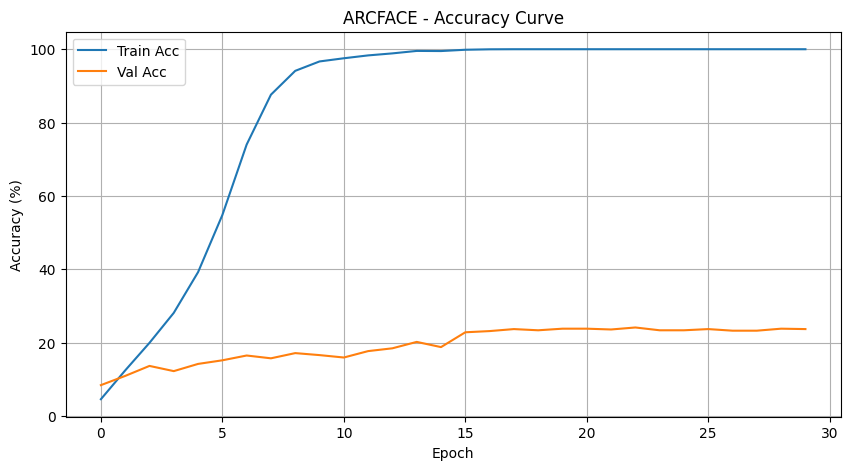

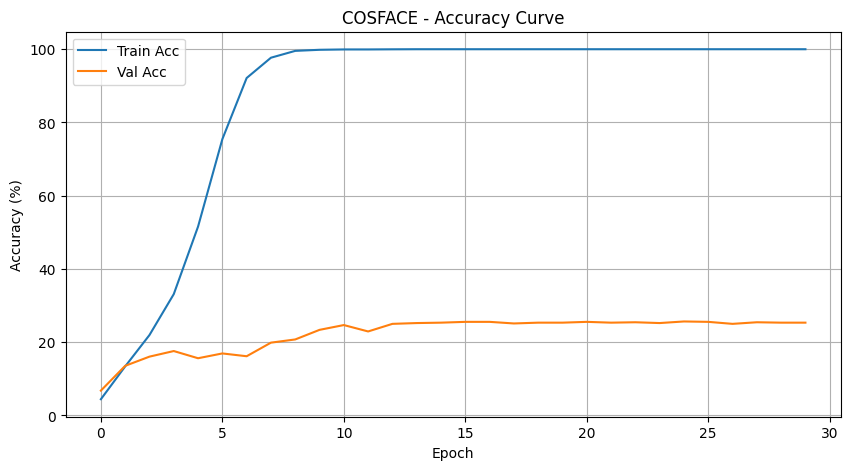

In [ ]:

# ArcFace Face Recognition - COMPLETE VERSION (Dynamic Quantization CPU)
#Part 1: Architecture & Training
#Part 2: Optimization & Evaluation + Comparison

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, auc
from scipy.interpolate import interp1d
from scipy.optimize import brentq
import time
import pandas as pd

# ==================== CONFIGURATION ====================
LFW_ROOT = '/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'
LFW_PAIRS_FILE = '/kaggle/input/lfw-pairs/lfw_pairs.txt' 

EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATE = 0.01
VAL_SPLIT = 0.1
ARCFACE_SCALE = 30.0
ARCFACE_MARGIN = 0.5
SAVE_PATH = "/kaggle/working/"
NUM_VERIFICATION_PAIRS = 6000 

# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# ==================== SEED SETUP ====================
def set_global_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_global_seed(42)

# ==================== DATASET CLASS ====================
class LFWDataset(Dataset):
    def __init__(self, root_dir, transform=None, min_images_per_identity=2):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.min_images_per_identity = min_images_per_identity

        image_files = []
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_files.append(os.path.join(root, file))

        if not image_files:
            raise ValueError(f"No images found in {root_dir}")

        self._load_identities(image_files)
        self._filter_min_images()
        print(f"Dataset ready: {len(self.samples)} images, {len(self.classes)} identities")

    def _load_identities(self, image_files):
        identity_to_idx = {}
        idx = 0
        for img_path in image_files:
            identity = os.path.basename(os.path.dirname(img_path))
            if identity not in identity_to_idx:
                identity_to_idx[identity] = idx
                idx += 1
            self.samples.append((img_path, identity_to_idx[identity]))
        self.classes = list(identity_to_idx.keys())
        self.class_to_idx = identity_to_idx

    def _filter_min_images(self):
        if self.min_images_per_identity <= 1:
            return
        counts = {}
        for _, label in self.samples:
            counts[label] = counts.get(label, 0) + 1
        valid_labels = {label for label, count in counts.items() if count >= self.min_images_per_identity}
        self.samples = [(p, l) for p, l in self.samples if l in valid_labels]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            return img, label
        except:
            return torch.randn(3, 112, 112), label

# ==================== ARCFACE LOSS ====================
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.5):
        super().__init__()
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.cos_m = np.cos(m)
        self.sin_m = np.sin(m)
        self.th = np.cos(np.pi - m)
        self.mm = np.sin(np.pi - m) * m

    def forward(self, embeddings, labels):
        embeddings = nn.functional.normalize(embeddings, p=2, dim=1)
        weight = nn.functional.normalize(self.weight, p=2, dim=1)
        cosine = torch.mm(embeddings, weight.t()).clamp(-1, 1)
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = torch.zeros(cosine.size(), device=embeddings.device)
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

# ==================== COSFACE LOSS ====================
class CosMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.35):
        super().__init__()
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, embeddings, labels):
        embeddings = nn.functional.normalize(embeddings, p=2, dim=1)
        weight = nn.functional.normalize(self.weight, p=2, dim=1)
        cosine = torch.mm(embeddings, weight.t())
        one_hot = torch.zeros(cosine.size(), device=embeddings.device)
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)
        output = cosine - one_hot * self.m
        output *= self.s
        return output

# ==================== MODEL OPTIMIZATION ====================
def optimize_model_for_inference(model, save_path):
    print("\n" + "="*60)
    print("MODEL OPTIMIZATION FOR INFERENCE (Dynamic Quantization on CPU)")
    print("="*60)
    
    model.eval()
    
    # نقل الموديل للـCPU
    model_cpu = model.to('cpu')
    
    # تطبيق Dynamic Quantization
    print("\nApplying Dynamic Quantization on Linear layers")
    quantized_model = torch.quantization.quantize_dynamic(
        model_cpu, {nn.Linear}, dtype=torch.qint8
    )
    
    # حفظ الموديل الكمّيتي
    torch.save(quantized_model.state_dict(), os.path.join(save_path, "model_quantized.pth"))
    print("Quantized model saved at:", os.path.join(save_path, "model_quantized.pth"))
    
    return quantized_model

# ==================== TRAINING FUNCTION ====================
def train_model(data_root, model_type='arcface', epochs=30, batch_size=64, lr=0.01):
    train_transform = transforms.Compose([
        transforms.Resize((112, 112)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    val_transform = transforms.Compose([
        transforms.Resize((112, 112)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    full_dataset = LFWDataset(data_root, transform=train_transform, min_images_per_identity=2)
    n_classes = len(full_dataset.classes)

    val_size = int(len(full_dataset) * VAL_SPLIT)
    train_size = len(full_dataset) - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size], 
        generator=torch.Generator().manual_seed(42)
    )
    val_dataset.dataset.transform = val_transform

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                            num_workers=2, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                           num_workers=2, pin_memory=True)

    # Model
    backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    backbone.fc = nn.Linear(backbone.fc.in_features, 512)
    backbone.to(device)

    # Loss head
    if model_type == 'arcface':
        loss_head = ArcMarginProduct(512, n_classes, s=ARCFACE_SCALE, m=ARCFACE_MARGIN).to(device)
    else:  # cosface
        loss_head = CosMarginProduct(512, n_classes, s=30.0, m=0.35).to(device)
    
    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD([
        {'params': backbone.parameters(), 'lr': lr},
        {'params': loss_head.parameters(), 'lr': lr}
    ], momentum=0.9, weight_decay=5e-4, nesterov=True)

    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=[int(epochs*0.5), int(epochs*0.75)], gamma=0.1
    )

    best_val_acc = 0.0
    train_accs, val_accs = [], []

    print(f"\n{'='*60}")
    print(f"Training {model_type.upper()} Model")
    print(f"{'='*60}")

    for epoch in range(epochs):
        backbone.train()
        loss_head.train()
        correct, total = 0, 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            feats = backbone(imgs)
            logits = loss_head(feats, labels)
            loss = criterion(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(backbone.parameters(), 5.0)
            optimizer.step()

            _, preds = logits.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()
            pbar.set_postfix({'acc': f'{100.*correct/total:.2f}%'})

        train_acc = 100.*correct/total
        train_accs.append(train_acc)

        # Validation
        backbone.eval()
        loss_head.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                feats = backbone(imgs)
                logits = loss_head(feats, labels)
                _, preds = logits.max(1)
                val_total += labels.size(0)
                val_correct += preds.eq(labels).sum().item()
        
        val_acc = 100.*val_correct/val_total
        val_accs.append(val_acc)
        scheduler.step()

        print(f"Epoch {epoch+1}: Train={train_acc:.2f}% | Val={val_acc:.2f}% | Best={best_val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(backbone.state_dict(), os.path.join(SAVE_PATH, f"best_{model_type}_model.pth"))

    torch.save(backbone.state_dict(), os.path.join(SAVE_PATH, f"final_{model_type}_model.pth"))

    plt.figure(figsize=(10,5))
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title(f"{model_type.upper()} - Accuracy Curve")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(SAVE_PATH, f"{model_type}_accuracy_curve.png"))

    return backbone

# ==================== MAIN ====================
if __name__ == '__main__':
    #  تدريب ArcFace
    print("\nTraining ArcFace Model")
    arcface_model = train_model(LFW_ROOT, model_type='arcface', epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LEARNING_RATE)
    
    #  تدريب CosFace (للمقارنة)
    print("\nTraining CosFace Model")
    cosface_model = train_model(LFW_ROOT, model_type='cosface', epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LEARNING_RATE)
    
    #  Model Optimization (Dynamic Quantization على CPU فقط)
    print("\nOptimizing ArcFace Model")
    quantized_model = optimize_model_for_inference(arcface_model, SAVE_PATH)
    
    print("\nALL TASKS COMPLETED")
    print(f"Quantized model saved to: {SAVE_PATH}")
